In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import FunctionTransformer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
# Load the data
data = pd.read_csv('train.csv')

In [4]:
# Check for missing values
print(data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


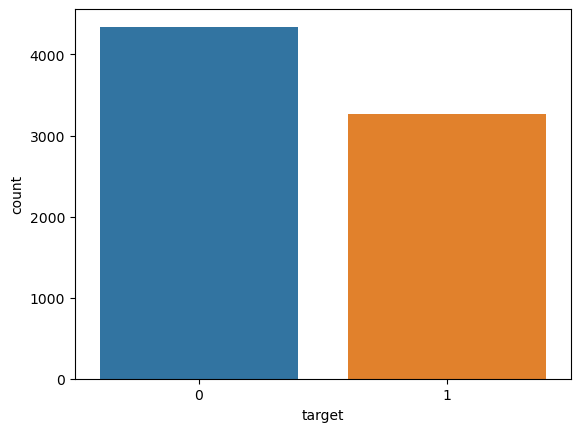

In [5]:
sns.countplot(x='target', data=data)
plt.show()

In [6]:
# Check for class imbalance
print(data['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64


In [7]:
# Check the number of unique keywords
print("Number of unique keywords:", data['keyword'].nunique())

Number of unique keywords: 221


In [8]:
# Check the number of unique locations
print("Number of unique locations:", data['location'].nunique())

Number of unique locations: 3341


In [9]:
# Analyze the text length
data['text_length'] = data['text'].apply(len)
print(data['text_length'].describe())

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64


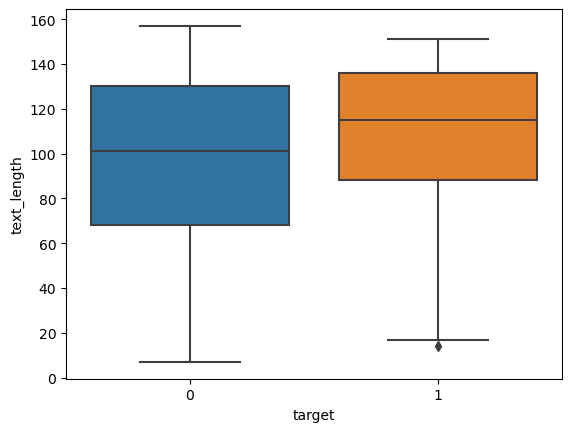

In [10]:
# Visualize the text length per each class
sns.boxplot(x='target', y='text_length', data=data)
plt.show()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
# Most common words in the text
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.text)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print('Most common words:', words_freq[:10])

Most common words: [('http', 4309), ('https', 411), ('like', 348), ('û_', 348), ('amp', 344), ('just', 323), ('new', 226), ('people', 200), ('news', 197), ('don', 190)]


In [13]:
# Shuffle training dataframe
data_shuffled = data.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility

In [14]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def preprocess_text(sen):
    # Remove urls
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sen, flags=re.MULTILINE)
    # Remove user @ references and '#' from sentence
    sentence = re.sub(r'\@\w+|\#','', sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # Convert to lower case
    sentence = sentence.lower()
    # Remove stop words and perform stemming
    sentence = sentence.split()
    ps = PorterStemmer()
    sentence = [
        ps.stem(word)
        for word in sentence
        if word not in set(stopwords.words('english'))
    ]
    sentence = ' '.join(sentence)
    return sentence

In [15]:
data_shuffled.head()

,id,keyword,location,text,target,text_length
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,66
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,119
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,125
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0,114
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0,105


In [16]:
data_shuffled['text'] = data_shuffled['text'].apply(preprocess_text)

In [45]:
# Most common words in the text
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.text)
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print('Most common words:', words_freq[:10])

Most common words: [('like', 411), ('amp', 344), ('bomb', 239), ('new', 227), ('news', 207), ('peopl', 200), ('time', 181), ('kill', 181), ('burn', 180), ('year', 178)]


In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
X = data_shuffled['text']
y = data_shuffled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [29]:
model_01 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

# Train the model
model_01.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Predict the labels
y_pred = model_01.predict(X_test)

In [31]:
def calculate_scores(y_test, y_pred):
    # Calculate the scores
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1) 

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }

In [32]:
baseline_model_results_01 = calculate_scores(y_test, y_pred)

Accuracy: 0.8031496062992126
Precision: 0.8138788984085914
Recall: 0.8031496062992126
F1 Score: 0.7990389367128067


In [33]:
# Tokenize and pad the text data
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

In [34]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [35]:
from tensorflow.keras.layers import GlobalAveragePooling1D

In [36]:
# Create the dense model
model_02 = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
], name="DenseModel")

In [37]:
model_02.summary()

Model: "DenseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile and train the model
model_02.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
dense_model_02 = model_02.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
191/191 - 1s - loss: 0.6810 - accuracy: 0.5721 - val_loss: 0.6785 - val_accuracy: 0.5634 - 1s/epoch - 7ms/step
Epoch 2/5
191/191 - 1s - loss: 0.6568 - accuracy: 0.5869 - val_loss: 0.6320 - val_accuracy: 0.6277 - 680ms/epoch - 4ms/step
Epoch 3/5
191/191 - 1s - loss: 0.5556 - accuracy: 0.7494 - val_loss: 0.5270 - val_accuracy: 0.7603 - 717ms/epoch - 4ms/step
Epoch 4/5
191/191 - 1s - loss: 0.4064 - accuracy: 0.8488 - val_loss: 0.4832 - val_accuracy: 0.7899 - 696ms/epoch - 4ms/step
Epoch 5/5
191/191 - 1s - loss: 0.3345 - accuracy: 0.8716 - val_loss: 0.4630 - val_accuracy: 0.7892 - 719ms/epoch - 4ms/step


In [39]:
# Evaluate the model
y_pred = (model_02.predict(X_val) > 0.5).astype("int32")

dense_model_results_02 = calculate_scores(y_val, y_pred)

48/48 [==============================] - 0s 980us/step
Accuracy: 0.7892317793827971
Precision: 0.7886326142097668
Recall: 0.7892317793827971
F1 Score: 0.7886805278992987


In [40]:
from keras.layers import LSTM, Dropout

In [41]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [42]:
# Split the data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(data_shuffled['text'], data_shuffled['target'], test_size=0.2, random_state=42)

# Define the parameters
max_features = 10000
embedding_dim = 128
sequence_length = 15

# Define the text vectorization layer
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Fit the text vectorization layer on the training data
vectorize_layer.adapt(X_train_lstm.to_list())

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy

In [44]:
# Define the LSTM model
input_layer = Input(shape=(1,), dtype=tf.string, name='input')
x_lstm = vectorize_layer(input_layer)
x_lstm = Embedding(max_features + 1, embedding_dim)(x_lstm)
x_lstm = LSTM(64)(x_lstm)
output_layer = Dense(1, activation='sigmoid', name='output')(x_lstm)

model_03 = tf.keras.Model(input_layer, output_layer, name="LSTM")

# Compile the model
model_03.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [45]:
model_03.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280128   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 1,329,601
Trainable params: 1,329,601
Non-trainable params: 0
____________________________________________________

In [46]:
# Train the model
model_03.fit(X_train_lstm, y_train_lstm, epochs=5, validation_split=0.1)

Epoch 1/5
172/172 [==============================] - 3s 8ms/step - loss: 0.5221 - accuracy: 0.7407 - val_loss: 0.4185 - val_accuracy: 0.8210
Epoch 2/5
172/172 [==============================] - 1s 6ms/step - loss: 0.2974 - accuracy: 0.8849 - val_loss: 0.4516 - val_accuracy: 0.7931
Epoch 3/5
172/172 [==============================] - 1s 7ms/step - loss: 0.1954 - accuracy: 0.9303 - val_loss: 0.5810 - val_accuracy: 0.7931
Epoch 4/5
172/172 [==============================] - 1s 6ms/step - loss: 0.1413 - accuracy: 0.9557 - val_loss: 0.6696 - val_accuracy: 0.7816
Epoch 5/5
172/172 [==============================] - 1s 6ms/step - loss: 0.1117 - accuracy: 0.9635 - val_loss: 0.7696 - val_accuracy: 0.7635


In [47]:
# Evaluate the model
y_pred = (model_03.predict(X_test_lstm) > 0.5).astype("int32")

lstm_model_results_03 = calculate_scores(y_test_lstm, y_pred)

48/48 [==============================] - 0s 3ms/step
Accuracy: 0.7688772160210111
Precision: 0.7683225943075519
Recall: 0.7688772160210111
F1 Score: 0.7684913693191304


In [48]:
from tensorflow.keras.layers import GRU

In [49]:
# Define the GRU model
input_layer = Input(shape=(1,), dtype=tf.string, name='input')
x_lstm = vectorize_layer(input_layer)
x_lstm = Embedding(max_features + 1, embedding_dim)(x_lstm)
x_lstm = LSTM(64)(x_lstm)
output_layer = Dense(1, activation='sigmoid', name='output')(x_lstm)

model_04 = tf.keras.Model(input_layer, output_layer, name="GRU")

# Compile the model
model_04.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [50]:
model_04.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280128   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 1,329,601
Trainable params: 1,329,601
Non-trainable params: 0
_____________________________________________________

In [51]:
# Train the model
model_04.fit(X_train_lstm, y_train_lstm, epochs=5, validation_split=0.1)

Epoch 1/5
172/172 [==============================] - 2s 8ms/step - loss: 0.5199 - accuracy: 0.7367 - val_loss: 0.4285 - val_accuracy: 0.8177
Epoch 2/5
172/172 [==============================] - 1s 6ms/step - loss: 0.2944 - accuracy: 0.8803 - val_loss: 0.4482 - val_accuracy: 0.8095
Epoch 3/5
172/172 [==============================] - 1s 6ms/step - loss: 0.1891 - accuracy: 0.9330 - val_loss: 0.5679 - val_accuracy: 0.7882
Epoch 4/5
172/172 [==============================] - 1s 6ms/step - loss: 0.1354 - accuracy: 0.9560 - val_loss: 0.6707 - val_accuracy: 0.7816
Epoch 5/5
172/172 [==============================] - 1s 6ms/step - loss: 0.1085 - accuracy: 0.9657 - val_loss: 0.8716 - val_accuracy: 0.7570


In [52]:
# Evaluate the model
y_pred = (model_04.predict(X_test_lstm) > 0.5).astype("int32")

gru_model_results_04 = calculate_scores(y_test_lstm, y_pred)

48/48 [==============================] - 0s 2ms/step
Accuracy: 0.762967826657912
Precision: 0.7643751617741735
Recall: 0.762967826657912
F1 Score: 0.7634313479127083


In [53]:
from keras.layers import Bidirectional

In [54]:
# Define the BiLSTM model
input_layer = Input(shape=(1,), dtype=tf.string, name='input')
x_lstm = vectorize_layer(input_layer)
x_lstm = Embedding(max_features + 1, embedding_dim)(x_lstm)
x_lstm = Bidirectional(LSTM(64))(x_lstm)
output_layer = Dense(1, activation='sigmoid', name='output')(x_lstm)

model_05 = tf.keras.Model(input_layer, output_layer, name="BiLSTM")

# Compile the model
model_05.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [55]:
model_05.summary()

Model: "BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280128   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 1,379,073
Trainable params: 1,379,073
Non-trai

In [56]:
# Train the model
model_05.fit(X_train_lstm, y_train_lstm, epochs=5, validation_split=0.1)

Epoch 1/5
172/172 [==============================] - 4s 12ms/step - loss: 0.5270 - accuracy: 0.7345 - val_loss: 0.4361 - val_accuracy: 0.8030
Epoch 2/5
172/172 [==============================] - 1s 8ms/step - loss: 0.2988 - accuracy: 0.8807 - val_loss: 0.4507 - val_accuracy: 0.7931
Epoch 3/5
172/172 [==============================] - 1s 8ms/step - loss: 0.1891 - accuracy: 0.9334 - val_loss: 0.5308 - val_accuracy: 0.7668
Epoch 4/5
172/172 [==============================] - 2s 9ms/step - loss: 0.1320 - accuracy: 0.9568 - val_loss: 0.5955 - val_accuracy: 0.7767
Epoch 5/5
172/172 [==============================] - 1s 9ms/step - loss: 0.1059 - accuracy: 0.9670 - val_loss: 0.8941 - val_accuracy: 0.7356


In [57]:
# Evaluate the model
y_pred = (model_05.predict(X_test_lstm) > 0.5).astype("int32")

bilstm_model_results_05 = calculate_scores(y_test_lstm, y_pred)

48/48 [==============================] - 1s 4ms/step
Accuracy: 0.7504924491135916
Precision: 0.7557267414267717
Recall: 0.7504924491135916
F1 Score: 0.7514355360589539


In [58]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [59]:
# Define the model
model_06 = Sequential(name="Conv1D")
model_06.add(Embedding(max_words, 128, input_length=max_len))
model_06.add(Conv1D(128, 5, activation='relu'))
model_06.add(GlobalMaxPooling1D())
model_06.add(Dense(1, activation='sigmoid'))
# Compile the model
model_06.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
model_06.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,362,177
Trainable params: 1,362,177
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Fit the model
model_06.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
191/191 [==============================] - 2s 5ms/step - loss: 0.5383 - accuracy: 0.7325 - val_loss: 0.4500 - val_accuracy: 0.8076
Epoch 2/5
191/191 [==============================] - 1s 4ms/step - loss: 0.3067 - accuracy: 0.8814 - val_loss: 0.4644 - val_accuracy: 0.8030
Epoch 3/5
191/191 [==============================] - 1s 4ms/step - loss: 0.1771 - accuracy: 0.9374 - val_loss: 0.5518 - val_accuracy: 0.8063
Epoch 4/5
191/191 [==============================] - 1s 4ms/step - loss: 0.1156 - accuracy: 0.9596 - val_loss: 0.6062 - val_accuracy: 0.7866
Epoch 5/5
191/191 [==============================] - 1s 4ms/step - loss: 0.0873 - accuracy: 0.9703 - val_loss: 0.6624 - val_accuracy: 0.7800


In [73]:
# Evaluate the model
y_pred = (model_06.predict(X_val) > 0.5).astype("int32")

conv1d_model_results_06 = calculate_scores(y_val, y_pred)

48/48 [==============================] - 0s 3ms/step
Accuracy: 0.7800393959290873
Precision: 0.7794701211487662
Recall: 0.7800393959290873
F1 Score: 0.7796046470141115


In [92]:
import numpy as np

Load the pre-trained model from TensorFlow Hub:

In [95]:
import tensorflow_hub as hub

In [96]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [97]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

In [98]:
X_train_embeddings = embed(X_train)
X_test_embeddings = embed(X_test)

In [99]:
from sklearn.linear_model import LogisticRegression

In [100]:
model_07 = LogisticRegression()
model_07.fit(X_train_embeddings, y_train)

LogisticRegression()

In [101]:
y_pred = model_07.predict(X_test_embeddings)
tfhub_model_results_07 = calculate_scores(y_test, y_pred)

Accuracy: 0.8220617202889035
Precision: 0.8217304568967476
Recall: 0.8220617202889035
F1 Score: 0.8209452400803882


In [103]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_model_results_01,
                                  "simple_dense": dense_model_results_02,
                                  "lstm": lstm_model_results_03,
                                  "gru": gru_model_results_04,
                                  "bidirectional": bilstm_model_results_05,
                                  "conv1d": conv1d_model_results_06,
                                  "tfhub": tfhub_model_results_07})
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy,Precision,Recall,F1 Score
baseline,0.803150,0.813879,0.803150,0.799039
simple_dense,0.789232,0.788633,0.789232,0.788681
lstm,0.768877,0.768323,0.768877,0.768491
gru,0.762968,0.764375,0.762968,0.763431
bidirectional,0.750492,0.755727,0.750492,0.751436
conv1d,0.780039,0.779470,0.780039,0.779605
tfhub,0.822062,0.821730,0.822062,0.820945


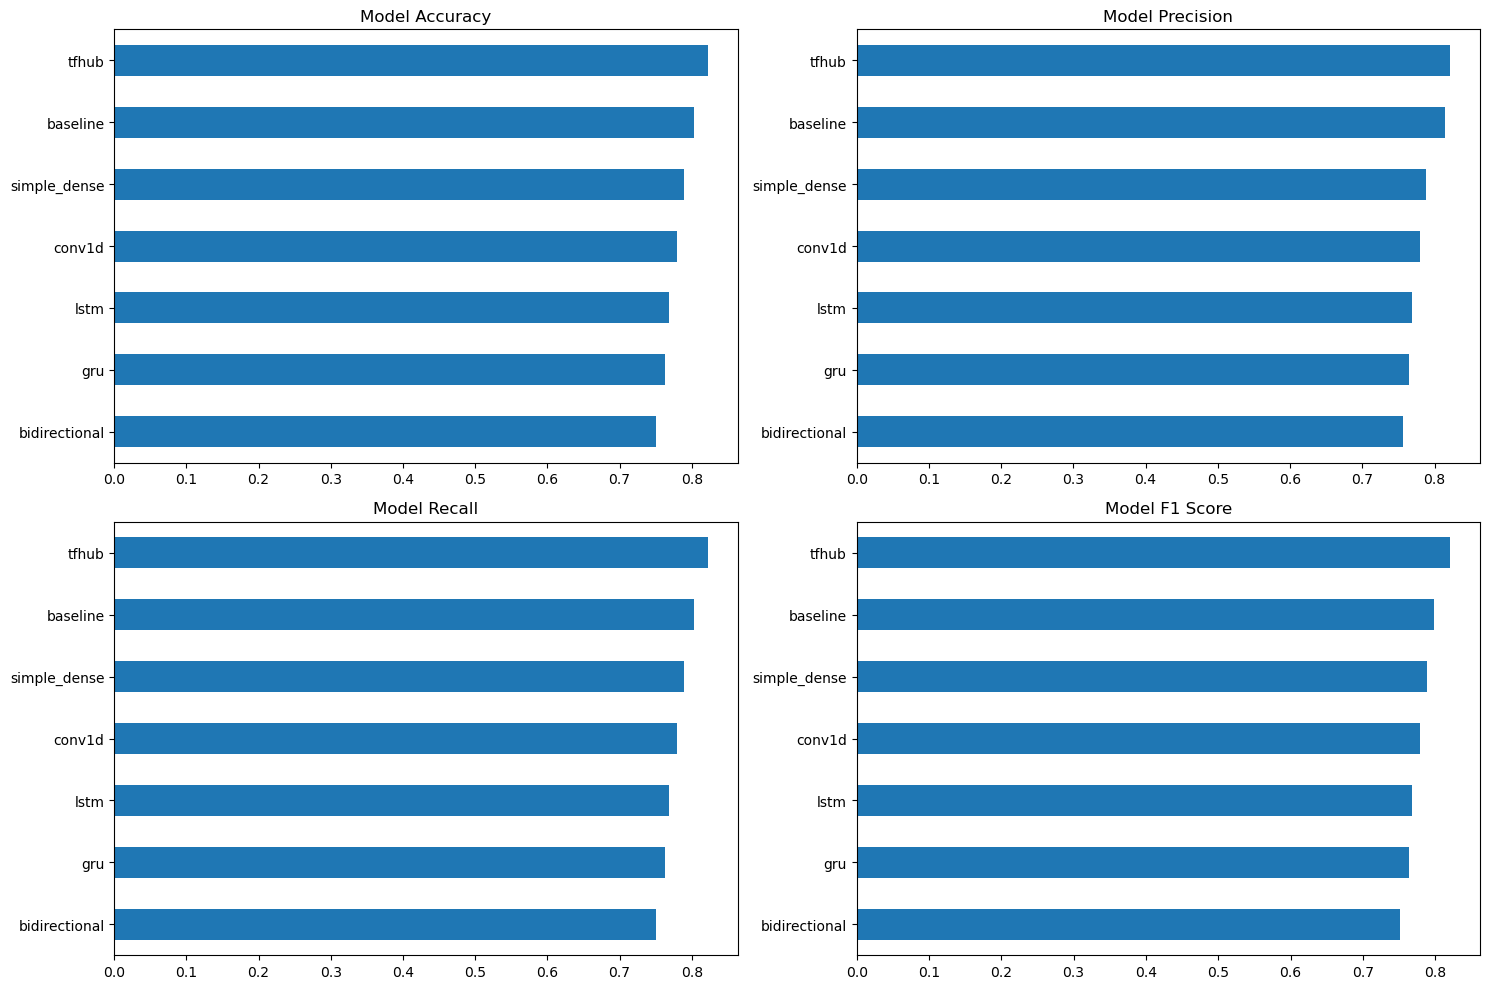

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(15,10))

# Subplot 1: Accuracy
plt.subplot(221)
all_model_results['Accuracy'].sort_values().plot(kind='barh', title='Model Accuracy')

# Subplot 2: Precision
plt.subplot(222)
all_model_results['Precision'].sort_values().plot(kind='barh', title='Model Precision')

# Subplot 3: Recall
plt.subplot(223)
all_model_results['Recall'].sort_values().plot(kind='barh', title='Model Recall')

# Subplot 4: F1 Score
plt.subplot(224)
all_model_results['F1 Score'].sort_values().plot(kind='barh', title='Model F1 Score')

plt.tight_layout()
plt.show()

In [112]:
# Calculate prediction probabilities
y_pred_prob = model_07.predict_proba(X_test_embeddings)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': y_pred,
    'prob_0': y_pred_prob[:, 0],
    'prob_1': y_pred_prob[:, 1]
})

# Calculate the probability of the correct class for each prediction
df['correct_prob'] = np.where(df['true_label'] == df['predicted_label'], np.max(y_pred_prob, axis=1), np.min(y_pred_prob, axis=1))

# Sort by correct_prob to find the most correct and most wrong predictions
most_correct = df.sort_values(by='correct_prob', ascending=False)
most_wrong = df.sort_values(by='correct_prob')

In [119]:
# Display the most correct predictions
print("Most correct predictions:")
most_correct.head(20)

Most correct predictions:


,text,true_label,predicted_label,prob_0,prob_1,correct_prob
2263,Businesses are deluged with invoices. Make you...,0,0,0.992580,0.007420,0.992580
3353,Entire town of Roosevelt Wash. evacuated becau...,1,1,0.007990,0.992010,0.992010
408,Arson suspect linked to 30 fires caught in Nor...,1,1,0.008158,0.991842,0.991842
4864,If your friends really were your friends they'...,0,0,0.988570,0.011430,0.988570
2264,Businesses are|deluged with invoices. Make y u...,0,0,0.988467,0.011533,0.988467
2164,Malaysia Airlines Flight 370 that Disappeared ...,1,1,0.012382,0.987618,0.987618
1047,ÛÏParties and body bags go together like drin...,0,0,0.986962,0.013038,0.986962
1302,The 8-Minute Fat-Burning Routine ThatÛªs Also...,0,0,0.986783,0.013217,0.986783
4691,Latest: Landslide kills three near Venice afte...,1,1,0.013553,0.986447,0.986447
3362,#Breaking: Authorities have issued new mandato...,1,1,0.014089,0.985911,0.985911


In [117]:
# Display the most wrong predictions
print("\nMost wrong predictions:")
most_wrong.head(20)


Most wrong predictions:


,text,true_label,predicted_label,prob_0,prob_1,correct_prob
2260,Businesses are deluged with invoices. Make you...,1,0,0.985819,0.014181,0.014181
6221,I get to smoke my shit in peace,1,0,0.968958,0.031042,0.031042
7203,Even if u have your weapon and your badge we g...,1,0,0.967421,0.032579,0.032579
547,STAR WARS POWER OF THE JEDI COLLECTION 1 BATTL...,1,0,0.963794,0.036206,0.036206
1005,'I did another one I did another one. You stil...,1,0,0.959786,0.040214,0.040214
842,I call it a little bit of your blizzard?,1,0,0.959138,0.040862,0.040862
3954,@adorableappple No reported flooding po in the...,0,1,0.046159,0.953841,0.046159
4509,My back is so sunburned :(,1,0,0.942359,0.057641,0.057641
2481,Me watching Law &amp; Order (IB: @sauldale305)...,1,0,0.939052,0.060948,0.060948
1817,@brianroemmele UX fail of EMV - people want to...,1,0,0.937615,0.062385,0.062385
